In [26]:
import tensorflow as tf
import matplotlib.pylab as plt
import tensorflowjs as tfjs

In [27]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [28]:
x_train = x_train[:,:,:,None] / 255.

validation_split = 0.05
n_val = int(len(x_train) * validation_split)
x_train, y_train = x_train[:-n_val], y_train[:-n_val]
x_val, y_val = x_train[-n_val:], y_train[-n_val:]

x_test = x_test[:,:,:,None] / 255.

x_train[x_train > 0.5] = 1.0
x_train[x_train <= 0.5] = 0.0

x_test[x_test > 0.5] = 1.0
x_test[x_test <= 0.5] = 0.0


In [29]:
# Add preprocessing
def pipeline(image, label):
    image = tf.image.resize_with_crop_or_pad(image, 36, 36)
    image = tf.image.random_crop(image, [28, 28, 1])
    image = image + tf.random.normal(shape=image.shape, stddev=0.1, dtype=tf.float64)    
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

In [30]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(pipeline).shuffle(1000).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [59]:
x = tf.keras.layers.Input(shape=[28, 28, 1])
net = tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation="relu")(x)
net = tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation="relu")(net)
net = tf.keras.layers.Flatten()(net)
net = tf.keras.layers.Dense(10)(net)

model = tf.keras.Model(inputs=x, outputs=net)

# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=[28, 28, 1]),
#     tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation="relu"),
#     tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation="relu"),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(10)
# ])

In [60]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [61]:
model.compile(
    optimizer='adam', 
    loss=loss,
    metrics=['accuracy']
)

In [62]:
model.fit(train_ds, epochs=5, validation_data=val_ds)

Train for 1782 steps, validate for 94 steps
Epoch 1/5
1782/1782 [==============================] - 27s 15ms/step - loss: 0.6798 - accuracy: 0.7826 - val_loss: 0.2336 - val_accuracy: 0.9323
Epoch 2/5
1782/1782 [==============================] - 26s 14ms/step - loss: 0.3979 - accuracy: 0.8812 - val_loss: 0.2050 - val_accuracy: 0.9400
Epoch 3/5
1782/1782 [==============================] - 28s 16ms/step - loss: 0.3345 - accuracy: 0.9002 - val_loss: 0.1941 - val_accuracy: 0.9407
Epoch 4/5
1782/1782 [==============================] - 27s 15ms/step - loss: 0.2996 - accuracy: 0.9093 - val_loss: 0.1883 - val_accuracy: 0.9420
Epoch 5/5
1782/1782 [==============================] - 27s 15ms/step - loss: 0.2754 - accuracy: 0.9178 - val_loss: 0.1245 - val_accuracy: 0.9610


In [63]:
model.evaluate(test_ds)

313/313 [==============================] - 1s 4ms/step - loss: 0.1454 - accuracy: 0.9560


[0.14542734614624003, 0.956]

In [64]:
predictions = tf.keras.Sequential([model, 
                                   tf.keras.layers.Softmax()])

In [65]:
p = predictions(x_test[0:10]).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [66]:
p.argmax(axis=1)

array([7, 2, 1, 0, 4, 1, 4, 4, 5, 9])

In [67]:
y_test[0:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8)

In [68]:
result = predictions.predict(x_test)

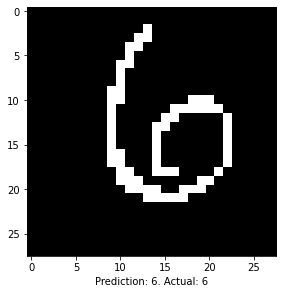

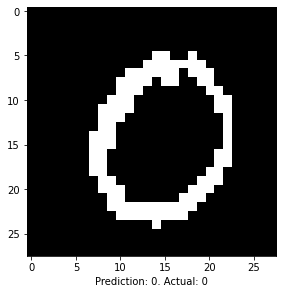

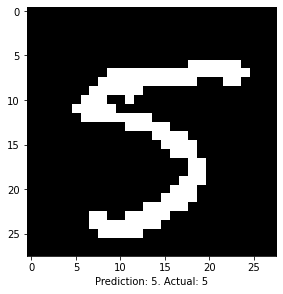

In [69]:
def plot_im_prediction(i):
    im = x_test[i]
    label = y_test[i]
    pred = predictions(im[None, :, :, :]).numpy().argmax(axis=1)[0]

    plt.imshow(im[:,:,0], cmap='gray')
    plt.tight_layout()
    plt.xlabel("Prediction: {}. Actual: {}".format(pred, label))
    plt.show()
    
plot_im_prediction(100)
plot_im_prediction(101)
plot_im_prediction(102)

### Save model in javascript format


In [71]:
tfjs.converters.save_keras_model(model, "./")